In [76]:
import os
from langchain.agents import create_agent
from dotenv import load_dotenv
from langfuse import get_client

from langfuse.langchain import CallbackHandler
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from db.milvus_handler import MilvusHandler
from langchain.messages import SystemMessage
from typing import Literal
from langgraph.graph import StateGraph, START, END
from messages_class import MessagesState
from langchain.messages import HumanMessage
from IPython.display import Image, display


load_dotenv()

# === Init Langfuse ===

langfuse = get_client()
# langfuse_client = 
langfuse_handler = CallbackHandler()

# === Init Milvus ===
milvus = MilvusHandler()



# EMBEDING / AI
api_key = os.getenv("OPENAI_API_KEY")
model = os.getenv("CHATBOT_MODEL_GENERATIVE")
embedding_model = os.getenv("CHATBOT_MODEL_EMBEDDING")
embeddings = OpenAIEmbeddings(model=embedding_model)

In [77]:

agent = init_chat_model(
    model=model,
)

agent_builder = StateGraph(MessagesState)

messages = [SystemMessage(content="Eşti un sistem profesionist de avocatură care vorbeşte limba română şi este specializat în Codul Penal şi legislaţia română.")]

query = HumanMessage(content="ce se intampla daca fur ? ")

In [78]:

def get_context(embedding):
    context = milvus.search(embedding, top_k=2)
    return context
    
def get_chatbot_answer(query: str, articles: list):
    """
    Generates a concise, professional answer in Romanian to a legal query using provided articles.

    Args:
        query (str): The user's legal question.
        articles (list): List of relevant articles or articles to use for context.

    Returns:
        str: The chatbot's answer in Romanian.
    """
    context = str(articles)
    completion = agent.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": f"""
                    --IDENTITY: A romanian lawyer that answers short and concise.
                    --TASK: You are going to answer the USER_QUERY by using CONTEXT.
                    --USER_QUERY: {query}
                    --CONTEXT: {context}
                """,
                }
            ]
        },
        config={"callbacks": [langfuse_handler]},
    )
    return completion["messages"][-1].content

def get_embedding(text: str):
    """
    Generates an embedding vector for the given text using OpenAI's embedding model.

    Args:
        text (str): The input text to embed.
        model (str, optional): The embedding model to use. Defaults to "text-embedding-3-large".

    Returns:
        list: The embedding vector for the input text.
    """
    with langfuse.start_as_current_observation(
        as_type="embedding",
        name="embedding-generation"
    ) as obs:
        try:
            vector = embeddings.embed_query(text)
            obs.update(output=vector)
            return vector
        except Exception as exc:
            print(f"Error generating embedding: {exc}")
            raise
             
def run_chatbot(question: str):
    """
    Generates and prints an answer to a legal question using embeddings and a chatbot.

    Args:
        question (str): The legal question to be answered.
    """
    embedding = get_embedding(question)
    context = get_context(embedding)
    print(context)
    answer_from_gpt = get_chatbot_answer(question, context)
    print(answer_from_gpt)
    return answer_from_gpt, context
  


In [79]:
# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("run_chatbot", run_chatbot)

# Add edges to connect nodes
agent_builder.add_edge(START, "")
agent_builder.add_edge("llm_call", "run_chatbot")
agent_builder.add_edge("run_chatbot", END)

# Compile the agent
agent_graph = agent_builder.compile()


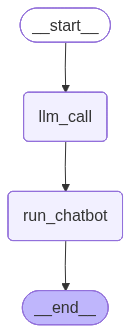

In [80]:
# Show the agent
display(Image(agent_graph.get_graph(xray=True).draw_mermaid_png()))


In [81]:
# Example usage
messages = [HumanMessage(content="Ce se intampla daca fur ?")]
new_state = agent_graph.invoke({"messages": messages})
for m in new_state["messages"]:
    m.pretty_print()




Error generating embedding: ('Input text for embedding is empty.', "text is {'messages': [HumanMessage(content='Ce se intampla daca fur ?', additional_kwargs={}, response_metadata={}), ChatPromptTemplate(input_variables=[], input_types={}, partial_variables={}, messages=[SystemMessage(content='Eşti un sistem profesionist de avocatură care vorbeşte limba română şi este specializat în Codul Penal şi legislaţia română.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Ce se intampla daca fur ?', additional_kwargs={}, response_metadata={})])], 'llm_calls': 1}")


ValueError: ('Input text for embedding is empty.', "text is {'messages': [HumanMessage(content='Ce se intampla daca fur ?', additional_kwargs={}, response_metadata={}), ChatPromptTemplate(input_variables=[], input_types={}, partial_variables={}, messages=[SystemMessage(content='Eşti un sistem profesionist de avocatură care vorbeşte limba română şi este specializat în Codul Penal şi legislaţia română.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Ce se intampla daca fur ?', additional_kwargs={}, response_metadata={})])], 'llm_calls': 1}")